In [1]:
from collections import OrderedDict, defaultdict
from enum import Enum
from pathlib import Path
from typing import Any, Callable, Mapping, Optional, Union
import collections
import math
import random
import os

import numpy as np
from numpy.random import RandomState

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

# For CLIP embeddings
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('high')

# set a flag to skip the 2d training
skip_2d_training = True

# not to self, layerxlayer is the conda env

# Diffusion Model
A model that generates layers of a voxelized 3D model one layer at a time through defusion.

The general idea of this is to do diffusion twice.

The first diffusion is done for each layer. Each layer goes through all diffusion time steps, and is combined at the end to be a 3D object.

This is done for x granularities of voxels, where each previous granularity informs the current granularity level.

In [2]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, channels, num_heads=8, dropout=0.2):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        
        num_groups = min(8, channels)
        while channels % num_groups != 0:
            num_groups -= 1
        self.norm = nn.GroupNorm(num_groups, channels)

        self.qkv = nn.Conv2d(channels, channels * 3, 1)  # 1x1 conv for Q, K, V
        self.proj = nn.Conv2d(channels, channels, 1)

        assert channels % num_heads == 0, f"channels {channels} must be divisible by num_heads {num_heads}"

        self.attn_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Normalize
        h = self.norm(x)
        
        # Get Q, K, V
        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for multi-head attention
        q = q.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)  # [B, heads, HW, head_dim]
        k = k.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)
        v = v.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)
        
        # Scaled dot-product attention
        scale = self.head_dim ** -0.5
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # [B, heads, HW, head_dim]
        out = out.transpose(2, 3).contiguous().view(B, C, H, W)
        
        # Project and add residual
        out = self.proj(out)
        return x + out
    

In [3]:
class MultiHeadCrossAttentionV1(nn.Module):
    """
    A more standard implementation where context is properly projected 
    and can attend to multiple positions
    """
    def __init__(self, channels, context_dim, num_heads=8, context_tokens=8):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.context_tokens = context_tokens

        self.norm = nn.GroupNorm(min(8, channels), channels)
        self.q = nn.Conv2d(channels, channels, 1)

        # Project context to key and value
        self.context_mlp_proj = nn.Sequential(
            nn.Linear(context_dim, context_dim * 2),
            nn.GELU(),
            nn.Linear(context_dim * 2, channels * self.context_tokens * 2)
        )
        
        # Final projection
        self.proj = nn.Conv2d(channels, channels, 1)

        self.context_pos_emb = nn.Parameter(
            torch.randn(1, self.context_tokens, channels) * 0.02
        )
        

        
    def forward(self, x, context):
        B, C, H, W = x.shape
        
        # Normalize spatial features
        h = self.norm(x)
        
        # Query from spatial features
        q = self.q(h)  # [B, C, H, W]
        q = q.view(B, self.num_heads, self.head_dim, H * W)
        q = q.permute(0, 1, 3, 2)  # [B, heads, HW, head_dim]
        
        # Project context to key and value
        context_proj = self.context_mlp_proj(context)  # [B, channels * context_tokens * 2]
        context_proj = context_proj.view(B, self.context_tokens, 2, self.channels)

        context_proj[:, :, 1] += self.context_pos_emb  # Add to V only  
        k, v = context_proj[:, :, 0], context_proj[:, :, 1]  # Each is [B, context_tokens, channels]
        
        # Add sequence dimension to k and v
        k = k.view(B, self.context_tokens, self.num_heads, self.head_dim)
        v = v.view(B, self.context_tokens, self.num_heads, self.head_dim)
        k = k.permute(0, 2, 1, 3)  # [B, heads, num_tokens, head_dim]
        v = v.permute(0, 2, 1, 3)  # [B, heads, num_tokens, head_dim]

        # Compute attention scores
        scale = self.head_dim ** -0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, heads, HW, 1]
        attn = F.softmax(scores, dim=-1)
        
        # Apply attention 
        out = torch.matmul(attn, v)
        
        # Reshape back to spatial dimensions
        out = out.permute(0, 1, 3, 2).contiguous()  # [B, heads, head_dim, HW]
        out = out.view(B, C, H, W)
        
        # Final projection and residual
        out = self.proj(out)
        return x + out

In [4]:
class MultiHeadCrossAttention(nn.Module):
    """Updated to handle both vector and sequence context"""
    def __init__(self, channels, context_dim, num_heads=2):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        self.norm = nn.GroupNorm(min(8, channels), channels)
        self.q = nn.Conv2d(channels, channels, 1)

        # Key and Value from context sequence
        self.to_kv = nn.Linear(context_dim, channels * 2)  # For both K and V
        
        self.proj = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x, context):
        """
        x: [B, C, H, W] - spatial features
        context: [B, seq_len, context_dim] - sequence of context vectors
        """
        B, C, H, W = x.shape
        
        # Normalize spatial features
        h = self.norm(x)
        
        # Query from spatial features
        q = self.q(h)  # [B, C, H, W]
        q = q.view(B, self.num_heads, self.head_dim, H * W)
        q = q.permute(0, 1, 3, 2)  # [B, heads, HW, head_dim]
        
        # Project context sequence to key and value
        seq_len = context.shape[1]
        kv = self.to_kv(context)  # [B, seq_len, channels * 2]
        kv = kv.view(B, seq_len, 2, self.num_heads, self.head_dim)
        k, v = kv[:, :, 0], kv[:, :, 1]  # Each is [B, seq_len, num_heads, head_dim]
        k = k.permute(0, 2, 1, 3)  # [B, num_heads, seq_len, head_dim]
        v = v.permute(0, 2, 1, 3)
        
        # Compute attention
        scale = self.head_dim ** -0.5
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, heads, HW, seq_len]
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # [B, heads, HW, head_dim]
        
        # Reshape back to spatial
        out = out.permute(0, 1, 3, 2).contiguous()
        out = out.view(B, C, H, W)
        
        # Output projection and residual
        out = self.proj(out)
        return x + out

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, channels, context_dim, num_heads=8, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(channels, num_heads, dropout)
        self.cross_attn = MultiHeadCrossAttention(channels, context_dim, num_heads)

        num_groups = min(8, channels)
        while channels % num_groups != 0:
            num_groups -= 1
    

        self.ffn = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.Conv2d(channels, channels * 4, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels * 4, channels, 1),
            nn.Dropout(dropout)
        )


    def forward(self, x, context):
        x = self.self_attn(x)
        x = self.cross_attn(x, context)
        return x + self.ffn(x)



In [6]:

# Using sinusoidal positional embeddings for time steps
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:  # zero pad
            emb = F.pad(emb, (0,1,0,0))
        return emb


# Enhanced ResNet Block with optional attention
class ResnetBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, context_dim, layer_context_dim = 64, 
    use_attention=False, num_heads=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)

        self.layer_mlp = nn.Sequential(
            nn.Linear(layer_context_dim, out_channels),
            nn.SiLU(),
            nn.Linear(out_channels, out_channels)
        ) 

        self.activation = nn.SiLU()
        
        # Add transformer block if specified
        self.use_attention = use_attention
        if use_attention:
            self.attention = TransformerBlock(out_channels, context_dim, num_heads=num_heads)

        # Shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t, context_emb, layer_context=None):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.activation(h)
        
        # Add time embedding
        h += self.time_mlp(t)[:, :, None, None]

        # Add layer context if provided
        if layer_context is not None:
            h += self.layer_mlp(layer_context)[:, :, None, None]

        h = self.activation(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.activation(h)
        
        # Apply attention if enabled
        if self.use_attention:
            h = self.attention(h, context_emb) # eventually add layer_context here too
        
        return h + self.shortcut(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, model_channels=128, context_dim=512, 
                 attention_resolutions=[8, 16]):
        """
        attention_resolutions: list of resolutions (H, W) where attention should be applied
        For 32x32 images: resolution 16 means we apply attention at 16x16 feature maps
        """
        super().__init__()
        self.model_channels = model_channels
        self.attention_resolutions = attention_resolutions
        
        # Time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            SinusoidalPosEmb(model_channels),
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Input
        self.input_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        
        # Down blocks with attention at specific resolutions
        # For 32x32 input: 32 -> 16 -> 8
        self.down_block1 = ResnetBlockWithAttention(
            model_channels, model_channels * 2, time_embed_dim, context_dim,
            use_attention=(32 in attention_resolutions)
        )
        self.down_block2 = ResnetBlockWithAttention(
            model_channels * 2, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(16 in attention_resolutions)
        )
        self.down_block3 = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(8 in attention_resolutions)
        )
        
        self.downsample1 = nn.MaxPool2d(2)
        self.downsample2 = nn.MaxPool2d(2)
        
        # Middle block with attention (always at lowest resolution)
        self.mid_block = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=True
        )
        
        # Up blocks with attention
        self.up_block1 = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(8 in attention_resolutions)
        )
        self.up_block2 = ResnetBlockWithAttention(
            model_channels * 4 + model_channels * 4, model_channels * 2, time_embed_dim, context_dim,
            use_attention=(16 in attention_resolutions)
        )
        self.up_block3 = ResnetBlockWithAttention(
            model_channels * 2 + model_channels * 2, model_channels, time_embed_dim, context_dim,
            use_attention=(32 in attention_resolutions)
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Output
        self.output_conv = nn.Conv2d(model_channels, in_channels, 3, padding=1)

    def forward(self, x, t, context, layer_context=None):
        # Time embedding
        time_emb = self.time_embed(t)

        # Input
        h = self.input_conv(x)

        # Downsampling with skip connections
        h1 = self.down_block1(h, time_emb, context)
        h = self.downsample1(h1)
        h2 = self.down_block2(h, time_emb, context)
        h = self.downsample2(h2)
        h3 = self.down_block3(h, time_emb, context)

        # Middle
        h = self.mid_block(h3, time_emb, context)

        # Upsampling with skip connections
        h = self.up_block1(h, time_emb, context)
        h = self.upsample1(h)
        h = torch.cat([h, h2], dim=1)
        h = self.up_block2(h, time_emb, context)
        h = self.upsample2(h)
        h = torch.cat([h, h1], dim=1)
        h = self.up_block3(h, time_emb, context)

        # Output
        return self.output_conv(h)



class ExponentialMovingAverage:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Initialize shadow weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        # Backup current parameters
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


In [7]:
# forward diffusion that creates a corrupted input
class ForwardDiffusion():
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

        # Precompute sqrt_alpha_hats and sqrt_one_minus_alpha_hats for efficiency
        self.sqrt_alpha_hats = torch.sqrt(self.alpha_hats)
        self.sqrt_one_minus_alpha_hats = torch.sqrt(1 - self.alpha_hats)

        # ensure all tensors are on the same device
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_hats = self.alpha_hats.to(device)
        self.sqrt_alpha_hats = self.sqrt_alpha_hats.to(device)
        self.sqrt_one_minus_alpha_hats = self.sqrt_one_minus_alpha_hats.to(device)

    def forward(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alpha_hat = self.sqrt_alpha_hats[t].view(-1, 1, 1, 1).to(x0.device)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hats[t].view(-1, 1, 1, 1).to(x0.device)
        
        xt = sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise
        return xt, noise

    def get_variance_schedule(self,t):
        # Return the variance at timestep t (posterior variance)

        if t == 0:
            return self.betas[0]
        else:
            alpha_hat_t = self.alpha_hats[t]
            alpha_hat_t_minus_1 = self.alpha_hats[t - 1]
            return self.betas[t] * (1 - alpha_hat_t_minus_1) / (1 - alpha_hat_t)


In [8]:
# Create a 2d difussion trainer
class DiffusionTrainer2D:
    def __init__(self, model, diffusion, scheduler):
        self.model = model # this is the noise predicting model (denoiser)
        self.diffusion = diffusion # this is the forward diffusion process (noise addition)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        self.scheduler = scheduler # can be None its the learning rate scheduler

    def train_step(self, x0, context):
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x0.size(0)
        t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=x0.device).long()
        xt, noise = self.diffusion.forward(x0, t)

        predicted_noise = self.model(xt, t.float(), context)
        loss = F.mse_loss(predicted_noise, noise)

        loss.backward()
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        return loss.item()
        
    def sample(self, context, shape, device):
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(shape, device=device)
            for t in reversed(range(self.diffusion.timesteps)):
                t_batch = torch.full((shape[0],), t, device=device, dtype=torch.float32)
                predicted_noise = self.model(x, t_batch, context)

                alpha_t = self.diffusion.alphas[t]
                alpha_hat_t = self.diffusion.alpha_hats[t]
                beta_t = self.diffusion.betas[t]

                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

            return x

In [9]:
class ExponentialMovingAverage:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Initialize shadow weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        # Backup current parameters
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


In [10]:
from torchvision import datasets
if not skip_2d_training:
    # sample dataset of grayscale cifar10 images
    class GrayscaleCIFAR10(Dataset):
        def __init__(self, root, train=True, transform=None, download=True):
            self.cifar10 = datasets.CIFAR10(root=root, train=train, transform=transform, download=download)

        def __len__(self):
            return len(self.cifar10)

        def __getitem__(self, idx):
            img, label = self.cifar10[idx]
            # Convert to grayscale
            img = img.convert("L")
            img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
            img = torch.from_numpy(img).unsqueeze(0)  # Add channel dimension
            return img, label


In [11]:
if not skip_2d_training:
    dataloader = DataLoader(GrayscaleCIFAR10(root='./data'), batch_size=64, shuffle=True, num_workers=4)

In [12]:
import torchvision
if not skip_2d_training:
    diffusion = ForwardDiffusion(timesteps=1000, beta_start=1e-4, beta_end=0.02)

    # Attention is applied at resolutions 8 and 16 (for 32x32 images)
    unet = UNet(
        in_channels=1, 
        model_channels=128, 
        context_dim=512, 
        attention_resolutions=[8, 16]  # Apply attention at 8x8 and 16x16 feature maps
    ).to(device)

    # Calculate and print model parameters
    total_params = sum(p.numel() for p in unet.parameters())
    print(f"Total parameters: {total_params:,}")

    trainer = DiffusionTrainer2D(unet, diffusion, scheduler=None)
    n_epochs = 10

    use_ema = True

    if use_ema:
        ema_model = ExponentialMovingAverage(unet, decay=0.999)

    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

    for epoch in range(n_epochs):
        epoch_loss = 0
        num_batches = 0
        
        for x0, label in dataloader:
            x0 = x0.to(device)

            # Get context embeddings from CLIP
            with torch.no_grad():
                text_inputs = torch.cat([clip.tokenize(f"a photo of a {dataloader.dataset.cifar10.classes[l]}") for l in label]).to(device)
                context = clip_model.encode_text(text_inputs).float()

            loss = trainer.train_step(x0, context)
            epoch_loss += loss
            num_batches += 1
            
            if use_ema:
                ema_model.update()
        
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

        # Sample and visualize
        if (epoch + 1) % 5 == 0:  
            if use_ema:
                ema_model.apply_shadow()
            
            # Grab random labels and get their context embeddings
            with torch.no_grad():
                random_labels = random.choices(range(10), k=4)
                text_inputs = torch.cat([clip.tokenize(f"a photo of a {dataloader.dataset.cifar10.classes[l]}") for l in random_labels]).to(device)
                sample_context = clip_model.encode_text(text_inputs).float()

                samples = trainer.sample(sample_context, shape=(4, 1, 32, 32), device=device)
                samples = samples.clamp(0, 1).cpu()
                grid = torchvision.utils.make_grid(samples, nrow=2)
                
                plt.figure(figsize=(6, 6))
                plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
                plt.title(f'Epoch {epoch+1} - Labels: {[dataloader.dataset.cifar10.classes[l] for l in random_labels]}')
                plt.axis('off')
                plt.show()
                
            if use_ema:
                ema_model.restore()



# Now that we have a 2D diffusion model, we need to make a wrapper around the model to generate layers of the same object

In [13]:
class CrossAttentionBlock(nn.Module):
    """
    Cross-attention block that attends from spatial features to a context vector.
    """
    def __init__(self, channels, context_dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        
        assert channels % num_heads == 0, f"channels {channels} must be divisible by num_heads {num_heads}"
        
        # Normalization
        num_groups = min(8, channels)
        while channels % num_groups != 0:
            num_groups -= 1
        self.norm = nn.GroupNorm(num_groups, channels)
        
        # Query from spatial features
        self.to_q = nn.Conv2d(channels, channels, 1)
        
        # Key and Value from context
        self.to_kv = nn.Linear(context_dim, channels * 2)
        
        # Output projection
        self.to_out = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        )
        
    def forward(self, x, context):
        """
        x: [B, C, H, W] - spatial features
        context: [B, context_dim] - context vector
        """
        B, C, H, W = x.shape
        
        # Normalize spatial features
        h = self.norm(x)
        
        # Get queries from spatial features
        q = self.to_q(h)  # [B, C, H, W]
        q = q.view(B, self.num_heads, self.head_dim, H * W)
        q = q.permute(0, 1, 3, 2)  # [B, num_heads, HW, head_dim]
        
        # Get keys and values from context
        kv = self.to_kv(context)  # [B, channels * 2]
        kv = kv.view(B, 2, self.num_heads, self.head_dim)
        k, v = kv[:, 0], kv[:, 1]  # Each is [B, num_heads, head_dim]
        
        # Add sequence dimension (since context is just one vector)
        k = k.unsqueeze(2)  # [B, num_heads, 1, head_dim]
        v = v.unsqueeze(2)  # [B, num_heads, 1, head_dim]
        
        # Compute attention
        scale = self.head_dim ** -0.5
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, num_heads, HW, 1]
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # [B, num_heads, HW, head_dim]
        
        # Reshape back to spatial
        out = out.permute(0, 1, 3, 2).contiguous()  # [B, num_heads, head_dim, HW]
        out = out.view(B, C, H, W)
        
        # Output projection and residual
        out = self.to_out(out)
        return x + out

class LayerXLayerDiffusionModel(nn.Module):
    def __init__(self, base_model: UNet, layer_context_dim=64, granularity=128):
        super().__init__()
        self.base_model = base_model
        self.layer_context_dim = layer_context_dim
        self.granularity = granularity
        
        # Positional encoding for layer index
        self.layer_pos_emb = SinusoidalPosEmb(layer_context_dim)
        
        # Project previous layer features to context space
        self.prev_layer_proj = nn.Sequential(
            nn.Conv2d(base_model.model_channels, layer_context_dim, 1),
            nn.GroupNorm(8, layer_context_dim),
            nn.SiLU()
        )
        
        # Combine layer position + previous layer info
        self.layer_context_mlp = nn.Sequential(
            nn.Linear(layer_context_dim * 2, layer_context_dim),
            nn.SiLU(),
            nn.Linear(layer_context_dim, layer_context_dim)
        )
        
        # Cross-attention to inject layer context into UNet
        self.layer_cross_attn = CrossAttentionBlock(
            channels=base_model.model_channels,
            context_dim=layer_context_dim,
            num_heads=8
        )

    def forward(self, x, t, l, context, prev_layer_features=None):
        """
        x: [B, C, H, W] - noisy input for current layer
        t: [B] - diffusion timestep
        l: [B] - layer index (0 to granularity-1)
        context: [B, context_dim] - global conditioning (e.g., CLIP)
        prev_layer_features: [B, C, H, W] - features from previous layer
        """
        batch_size = x.size(0)
        
        # Create layer context encoding
        layer_pos = self.layer_pos_emb(l.float())  # [B, layer_context_dim]
        
        if prev_layer_features is not None:
            # Project previous layer to context space and pool spatially
            prev_layer_ctx = self.prev_layer_proj(prev_layer_features)  # [B, layer_context_dim, H, W]
            prev_layer_ctx = prev_layer_ctx.mean(dim=[-2, -1])  # [B, layer_context_dim]
            
            # Combine position and previous layer info
            layer_ctx = torch.cat([layer_pos, prev_layer_ctx], dim=-1)  # [B, layer_context_dim*2]
        else:
            # First layer - just use position
            layer_ctx = torch.cat([layer_pos, torch.zeros_like(layer_pos)], dim=-1)
        
        layer_ctx = self.layer_context_mlp(layer_ctx)  # [B, layer_context_dim]
        
        # Pass through base UNet with layer context
        out = self.base_model(x, t, context, layer_ctx)
    
        
        return out, prev_layer_features

    @torch.no_grad()
    def generate_all_layers(self, shape, global_context, device, num_inference_steps=50):
        """
        Generate all layers sequentially from pure noise.
        """
        from diffusers import DDPMScheduler
        scheduler = DDPMScheduler(num_train_timesteps=1000)
        scheduler.set_timesteps(num_inference_steps)
        
        layers = []
        prev_layer_features = None
        
        for layer_idx in range(self.granularity):
            # Start from noise for this layer
            x = torch.randn(shape, device=device)
            l = torch.full((shape[0],), layer_idx, device=device, dtype=torch.long)
            
            # Denoise this layer
            for t in scheduler.timesteps:
                t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
                
                # Predict noise
                noise_pred = self.forward(
                    x, t_batch, l, global_context, prev_layer_features
                )
                
                # Denoise step
                x = scheduler.step(noise_pred, t, x).prev_sample
            
            layers.append(x)
            prev_layer_features = x.detach()  # Use clean layer as context for next
        
        return torch.stack(layers, dim=1)  # [B, granularity, C, H, W]

# create the 3d voxel dataset 
(inside the folder_path_{granularity}, there are .npy files of shape (granularity, granularity, granularity) with values in [0, 1])
the user will make a voxel dataset object for each granularity they want to train on

In [37]:
import concurrent.futures
from pathlib import Path
import threading

class VoxelDataset(Dataset):
    def __init__(self, npy_folder_path, description_folder_path, transform=None, granularity=128, test_count=0):
        self.npy_folder_path = npy_folder_path
        self.description_folder_path = description_folder_path
        self.transform = transform
        self.granularity = granularity
       
        print("Loading file lists...")
        npy_path = Path(npy_folder_path)

        # Limit dataset size for testing
        if test_count > 0:
            file_list = []
            for entry in os.scandir(npy_folder_path):
                if entry.name.endswith('.npy') and entry.is_file():
                    file_list.append(npy_path / entry.name)
                    if len(file_list) >= test_count:
                        break

            print(f" TEST MODE: Using only {len(file_list)} samples")
        else:
            file_list = [
            npy_path / entry.name 
            for entry in os.scandir(npy_folder_path) 
            if entry.name.endswith('.npy') and entry.is_file()
        ]

        self.file_list = file_list

        if test_count > 0:
            print(self.file_list)

        print(f"Loading {len(self.file_list)} descriptions in parallel...")
        # Parallel description loading (only for files we're using)
        self.descriptions = self._load_descriptions_parallel()
       
        print(f"Found {len(self.file_list)} .npy files in {npy_folder_path}")
        print(f"Found {len(self.descriptions)} descriptions in {description_folder_path}")
        print(f"Voxel grid granularity: {self.granularity}x{self.granularity}x{self.granularity}")
   
    def _load_descriptions_parallel(self):
        """Load all description files in parallel"""
        # Only load descriptions for files we're actually using
        needed_stems = {f.stem for f in self.file_list}
        desc_files = [f for f in Path(self.description_folder_path).glob("*.txt") 
                      if f.stem in needed_stems]
        descriptions = {}
       
        def load_single_description(desc_file):
            try:
                with open(desc_file, 'r') as f:
                    return desc_file.stem, f.read().strip()
            except Exception as e:
                print(f"Error loading {desc_file}: {e}")
                return desc_file.stem, "A 3D object"  # fallback
       
        # Use ThreadPoolExecutor for I/O bound operations
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            results = executor.map(load_single_description, desc_files)
            descriptions.update(results)
       
        return descriptions
    
    def __len__(self):
        return len(self.file_list)
   
    def __getitem__(self, idx):
        voxel_grid = np.load(self.file_list[idx]).astype(np.float32)  # shape (granularity, granularity, granularity)
        assert voxel_grid.shape == (self.granularity, self.granularity, self.granularity), f"Voxel grid shape {voxel_grid.shape} does not match expected shape {(self.granularity, self.granularity, self.granularity)}"
       
        if self.transform:
            voxel_grid = self.transform(voxel_grid)
       
        voxel_grid = torch.from_numpy(voxel_grid).unsqueeze(0)  # Add channel dimension -> shape (1, granularity, granularity, granularity)
        filename_key = self.file_list[idx].stem
        description = self.descriptions.get(filename_key, "A 3D object")  # Default description if not found
        return voxel_grid, description

In [38]:
# create a 3d difussion trainer for the layer x layer model

class LayerXLayerDiffusionTrainer:
    def __init__(self, model: LayerXLayerDiffusionModel, diffusion: ForwardDiffusion, scheduler, layer_by_layer_convergence=True):
        self.model = model  # this is the layer x layer diffusion model
        self.diffusion = diffusion  # this is the forward diffusion process (noise addition)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        self.scheduler = scheduler  # can be None its the learning rate scheduler
        self.layer_by_layer_convergence = layer_by_layer_convergence

    def train_step(self, x0, context):
        """
        x0: [B, C, H, W] the full object with all layers
        context: [B, context_dim] the global context (e.g. CLIP embedding)
        """
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x0.size(0)
        device = x0.device

        # Initialize previous layer features to None
        prev_layer_features = None

        total_loss = 0

        # Iterate over each layer
        for layer_idx in range(self.model.granularity):
            # Extract the current layer from x0
            current_layer = x0[:, :, :, layer_idx]  # [B, C, H, W-layer_idx]

            # Randomly sample a timestep for this layer
            t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=device).long()

            # Add noise to the current layer
            xt, noise = self.diffusion.forward(current_layer, t)

            # Create a tensor for the current layer index
            l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

            # Predict noise using the model
            predicted_noise, prev_layer_features = self.model(xt, t.float(), l, context, prev_layer_features)

            # Compute loss for this layer
            loss = F.mse_loss(predicted_noise, noise)
            total_loss += loss.detach()
            loss.backward()

        # Backpropagate and optimize
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        avg_loss = total_loss / self.model.granularity
        return avg_loss, prev_layer_features

    def layer_convergence_sample(self, context, shape, device):
        """
        context: [B, seq_len, context_dim] the global context (e.g. T5 embedding)
        shape: (B, C, H, W) the shape of each layer to generate
        """
        self.model.eval()
        with torch.no_grad():
            batch_size = shape[0]
            prev_layer_features = None

            # Initialize voxel grid with correct dimensions: [B, C, H, W, D]
            voxel_grid = torch.zeros((batch_size, shape[1], shape[2], shape[3], self.model.granularity), device=device)

            for layer_idx in range(self.model.granularity):
                # Create a tensor for the current layer index
                l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

                # Start with pure noise for this layer
                x = torch.randn(shape, device=device)

                # Run diffusion to convergence for this layer
                for t in reversed(range(self.diffusion.timesteps)):
                    t_batch = torch.full((batch_size,), t, device=device, dtype=torch.float32)
                    predicted_noise, prev_layer_features = self.model(x, t_batch, l, context, prev_layer_features)

                    alpha_t = self.diffusion.alphas[t]
                    alpha_hat_t = self.diffusion.alpha_hats[t]
                    beta_t = self.diffusion.betas[t]

                    if t > 0:
                        noise = torch.randn_like(x)
                    else:
                        noise = torch.zeros_like(x)

                    x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

                # Place the generated layer into the voxel grid at the correct position
                voxel_grid[:, :, :, :, layer_idx] = x

            return voxel_grid.clamp(0, 1)  # Return the full voxel grid [B, C, H, W, D]

        
    def object_convergence_sample(self, context, shape, device):
        """
        context: [B, context_dim] the global context (e.g. CLIP embedding)
        shape: (B, C, H, W) the shape of each layer to generate
        """
        self.model.eval()
        with torch.no_grad():
            batch_size = shape[0]
            device = context.device

            # Initialize an empty voxel grid
            voxel_grid = torch.zeros((batch_size, shape[1], shape[2], self.model.granularity), device=device)

            # Start with pure noise for the entire object
            x = torch.randn((batch_size, shape[1], shape[2], self.model.granularity), device=device)

            # Randomly sample a timestep for the entire object
            t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=device).long()

            # Initialize previous layer features to None
            prev_layer_features = None

            for layer_idx in range(self.model.granularity):
                # Create a tensor for the current layer index
                l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

                # Extract the current layer from x
                current_layer = x[:, :, :, layer_idx]  # [B, C, H, W-layer_idx]

                # Predict noise using the model
                predicted_noise, prev_layer_features = self.model(current_layer, t.float(), l, context, prev_layer_features)

                alpha_t = self.diffusion.alphas[t]
                alpha_hat_t = self.diffusion.alpha_hats[t]
                beta_t = self.diffusion.betas[t]

                if layer_idx < self.model.granularity - 1:
                    noise = torch.randn_like(current_layer)
                else:
                    noise = torch.zeros_like(current_layer)

                # Update the current layer in x
                x[:, :, :, layer_idx] = (1 / torch.sqrt(alpha_t)) * (current_layer - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

                # Place the updated layer into the voxel grid
                voxel_grid[:, :, :, layer_idx] = x[:, :, :, layer_idx]

            return voxel_grid.clamp(0, 1)  # Return the full voxel grid
        

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from pathlib import Path
from tqdm import tqdm

class TrainingVoxelVisualizer:
    """Visualizer for 3D voxel generation during training"""
    
    def __init__(self, save_dir='./training_samples', max_voxels=30000):
        """
        Args:
            save_dir: Directory to save visualization images
            max_voxels: Maximum voxels to render per view for performance
        """
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.max_voxels = max_voxels
        
    def visualize_single_voxel(self, voxel_grid, ax, view_angle=(30, 45), 
                              colormap='viridis', point_size=10, alpha=0.6):
        """
        Visualize a single voxel grid on a given axis.
        
        Args:
            voxel_grid: numpy array of shape (H, W, D)
            ax: matplotlib 3D axis
            view_angle: tuple of (elevation, azimuth)
            colormap: matplotlib colormap name
            point_size: size of voxel points
            alpha: transparency
        """
        # Find occupied voxels
        occupied_coords = np.where(voxel_grid > 0)
        num_occupied = len(occupied_coords[0])
        
        if num_occupied == 0:
            ax.text2D(0.5, 0.5, "No voxels", transform=ax.transAxes,
                     ha='center', va='center', fontsize=12)
            return 0
        
        # Subsample if too many voxels
        if num_occupied > self.max_voxels:
            indices = np.random.choice(num_occupied, self.max_voxels, replace=False)
            x_coords = occupied_coords[0][indices]
            y_coords = occupied_coords[1][indices]
            z_coords = occupied_coords[2][indices]
        else:
            x_coords = occupied_coords[0]
            y_coords = occupied_coords[1]
            z_coords = occupied_coords[2]
        
        # Plot voxels
        scatter = ax.scatter(x_coords, y_coords, z_coords,
                           c=z_coords, cmap=colormap,
                           alpha=alpha, s=point_size, edgecolors='none')
        
        # Set viewing angle
        ax.view_init(elev=view_angle[0], azim=view_angle[1])
        
        # Set labels and limits
        ax.set_xlabel('X', fontsize=8)
        ax.set_ylabel('Y', fontsize=8)
        ax.set_zlabel('Z', fontsize=8)
        
        max_range = max(voxel_grid.shape)
        ax.set_xlim(0, max_range)
        ax.set_ylim(0, max_range)
        ax.set_zlim(0, max_range)
        
        # Styling
        ax.grid(True, alpha=0.3)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        return num_occupied
    
    def visualize_training_samples(self, trainer, epoch, num_samples=4, 
                                   descriptions=None, context_encoder=None,
                                   tokenizer=None, granularity=64, device='cuda',
                                   view_angles=[(30, 45), (60, 120)],
                                   colormap='viridis', show_slices=True,
                                   show_progress=True):
        """
        Generate and visualize samples during training.
        
        Args:
            trainer: LayerXLayerDiffusionTrainer instance
            epoch: Current epoch number
            num_samples: Number of samples to generate
            descriptions: List of text descriptions (if None, uses defaults)
            context_encoder: Model for encoding text (e.g., T5)
            tokenizer: Tokenizer for text encoding
            granularity: Voxel grid resolution
            device: Device to run on
            view_angles: List of (elevation, azimuth) tuples for 3D views
            colormap: Matplotlib colormap
            show_slices: Whether to show 2D slice views as well
            show_progress: Whether to show progress bars
        """
        print(f"\n{'='*60}")
        print(f"Generating Epoch {epoch} Visualizations")
        print(f"{'='*60}")
        
        # Default descriptions if none provided
        if descriptions is None:
            descriptions = [
                "A simple cube",
                "A sphere",
                "A pyramid",
                "An abstract shape"
            ][:num_samples]
        
        # Encode descriptions to context embeddings
        with torch.no_grad():
            if show_progress:
                print("Encoding text descriptions...")
            
            if context_encoder is not None and tokenizer is not None:
                text_inputs = tokenizer(
                    list(descriptions),
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
                
                context = context_encoder(
                    input_ids=text_inputs.input_ids,
                    attention_mask=text_inputs.attention_mask
                ).last_hidden_state
            else:
                # Fallback: random context if encoder not provided
                context = torch.randn(num_samples, 77, 768).to(device)
            
            # Generate samples with progress tracking
            if show_progress:
                print(f"Generating {num_samples} voxel samples ({granularity}³ resolution)...")
                samples = self._generate_with_progress(
                    trainer, context, num_samples, granularity, device
                )
            else:
                samples = trainer.layer_convergence_sample(
                    context,
                    shape=(num_samples, 1, granularity, granularity),
                    device=device
                )
            
            samples = samples.clamp(0, 1).cpu().numpy()
        
        # Create visualization
        if show_progress:
            print("Creating visualization plots...")
        
        num_views = len(view_angles)
        
        if show_slices:
            # Show both 3D views and 2D slices
            fig = plt.figure(figsize=(5 * (num_views + 1), 4 * num_samples))
            
            iterator = tqdm(range(num_samples), desc="Plotting samples", disable=not show_progress)
            for i in iterator:
                voxel_grid = samples[i, 0]  # [H, W, D]
                
                # 3D views
                for j, (elev, azim) in enumerate(view_angles):
                    ax = fig.add_subplot(num_samples, num_views + 1, 
                                        i * (num_views + 1) + j + 1, 
                                        projection='3d')
                    
                    num_voxels = self.visualize_single_voxel(
                        voxel_grid, ax, view_angle=(elev, azim),
                        colormap=colormap
                    )
                    
                    if j == 0:
                        # Truncate description for display
                        desc_short = (descriptions[i][:30] + '...') if len(descriptions[i]) > 30 else descriptions[i]
                        ax.set_title(f'{desc_short}\n{num_voxels:,} voxels\nView: {elev}°, {azim}°', 
                                   fontsize=10)
                    else:
                        ax.set_title(f'View: {elev}°, {azim}°', fontsize=10)
                
                # 2D slice view
                ax_slice = fig.add_subplot(num_samples, num_views + 1, 
                                          i * (num_views + 1) + num_views + 1)
                mid_slice = voxel_grid[:, :, granularity // 2]
                ax_slice.imshow(mid_slice, cmap='gray', vmin=0, vmax=1)
                ax_slice.set_title(f'Middle Slice (z={granularity//2})', fontsize=10)
                ax_slice.axis('off')
        else:
            # Only 3D views
            fig = plt.figure(figsize=(5 * num_views, 4 * num_samples))
            
            iterator = tqdm(range(num_samples), desc="Plotting samples", disable=not show_progress)
            for i in iterator:
                voxel_grid = samples[i, 0]  # [H, W, D]
                
                for j, (elev, azim) in enumerate(view_angles):
                    ax = fig.add_subplot(num_samples, num_views, 
                                        i * num_views + j + 1, 
                                        projection='3d')
                    
                    num_voxels = self.visualize_single_voxel(
                        voxel_grid, ax, view_angle=(elev, azim),
                        colormap=colormap
                    )
                    
                    if j == 0:
                        desc_short = (descriptions[i][:30] + '...') if len(descriptions[i]) > 30 else descriptions[i]
                        ax.set_title(f'{desc_short}\n{num_voxels:,} voxels', fontsize=10)
        
        plt.suptitle(f'Epoch {epoch} - Generated Voxel Samples', 
                    fontsize=14, y=0.995)
        plt.tight_layout()
        
        # Save figure
        save_path = self.save_dir / f'epoch_{epoch:04d}_samples.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        if show_progress:
            print(f"✓ Visualization saved to: {save_path}")
            print(f"{'='*60}\n")
        
        # Display in notebook
        plt.show()
        plt.close()
        
        return samples
    
    def _generate_with_progress(self, trainer, context, num_samples, granularity, device):
        """
        Generate samples with a progress bar showing layer-by-layer progress.
        This is a wrapper around the trainer's generation method.
        """
        trainer.model.eval()
        with torch.no_grad():
            batch_size = num_samples
            prev_layer_features = None
            shape = (num_samples, 1, granularity, granularity)
            
            # Initialize voxel grid with correct dimensions: [B, C, H, W, D]
            voxel_grid = torch.zeros((batch_size, shape[1], shape[2], shape[3], trainer.model.granularity), device=device)

            # Progress bar for layers
            layer_pbar = tqdm(range(trainer.model.granularity), desc="Generating layers", unit="layer")
            
            for layer_idx in layer_pbar:
                # Create a tensor for the current layer index
                l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

                # Start with pure noise for this layer
                x = torch.randn(shape, device=device)

                # Progress bar for diffusion timesteps (nested)
                timestep_pbar = tqdm(
                    reversed(range(trainer.diffusion.timesteps)), 
                    desc=f"  Layer {layer_idx+1}/{trainer.model.granularity} diffusion",
                    leave=False,
                    total=trainer.diffusion.timesteps,
                    unit="step"
                )

                # Run diffusion to convergence for this layer
                for t in timestep_pbar:
                    t_batch = torch.full((batch_size,), t, device=device, dtype=torch.float32)
                    predicted_noise, prev_layer_features = trainer.model(x, t_batch, l, context, prev_layer_features)

                    alpha_t = trainer.diffusion.alphas[t]
                    alpha_hat_t = trainer.diffusion.alpha_hats[t]
                    beta_t = trainer.diffusion.betas[t]

                    if t > 0:
                        noise = torch.randn_like(x)
                    else:
                        noise = torch.zeros_like(x)

                    x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
                
                timestep_pbar.close()

                # Place the generated layer into the voxel grid at the correct position
                voxel_grid[:, :, :, :, layer_idx] = x
                
                # Update layer progress bar with completion percentage
                layer_pbar.set_postfix({'completed': f'{((layer_idx+1)/trainer.model.granularity)*100:.1f}%'})

            layer_pbar.close()
            return voxel_grid.clamp(0, 1)


# Integration function to add to training loop
def visualize_epoch_samples(trainer, epoch, visualizer, dataset, 
                           context_encoder, tokenizer, granularity, device,
                           num_samples=4, show_progress=True):
    """
    Convenience function to call in training loop.
    
    Args:
        trainer: LayerXLayerDiffusionTrainer instance
        epoch: Current epoch number
        visualizer: TrainingVoxelVisualizer instance
        dataset: Dataset object with descriptions
        context_encoder: Model for encoding text (e.g., T5)
        tokenizer: Tokenizer for text encoding
        granularity: Voxel grid resolution
        device: Device to run on
        num_samples: Number of samples to generate
        show_progress: Whether to show progress bars
    
    Example usage in training loop:
        if (epoch + 1) % 10 == 0:
            visualize_epoch_samples(
                trainer=layer_x_layer_trainer,
                epoch=epoch,
                visualizer=voxel_visualizer,
                dataset=dataloader_3d.dataset,
                context_encoder=t5_model,
                tokenizer=t5_tokenizer,
                granularity=granularity,
                device=device,
                num_samples=4,
                show_progress=True
            )
    """
    # Get random descriptions from dataset
    import random
    
    # Default descriptions if dataset has none
    default_descriptions = [
        "A 3D geometric shape",
        "An abstract voxel object",
        "A simple 3D structure",
        "A complex voxel model",
        "A creative 3D design",
        "An artistic voxel sculpture",
        "A minimalist 3D form",
        "A detailed voxel creation"
    ]
    
    # Try to get descriptions from dataset
    if hasattr(dataset, 'descriptions') and dataset.descriptions:
        available_descriptions = list(dataset.descriptions.values())
        
        if len(available_descriptions) >= num_samples:
            # Enough descriptions available, sample without replacement
            random_descriptions = random.sample(available_descriptions, k=num_samples)
        elif len(available_descriptions) > 0:
            # Some descriptions available, but not enough - use what we have and fill with defaults
            random_descriptions = available_descriptions[:num_samples]
            if len(random_descriptions) < num_samples:
                # Fill remaining with defaults
                num_needed = num_samples - len(random_descriptions)
                random_descriptions.extend(random.sample(default_descriptions, k=num_needed))
        else:
            # No descriptions available
            random_descriptions = random.sample(default_descriptions, k=num_samples)
    else:
        # Dataset doesn't have descriptions attribute
        random_descriptions = random.sample(default_descriptions, k=num_samples)
    
    visualizer.visualize_training_samples(
        trainer=trainer,
        epoch=epoch,
        num_samples=num_samples,
        descriptions=random_descriptions,
        context_encoder=context_encoder,
        tokenizer=tokenizer,
        granularity=granularity,
        device=device,
        view_angles=[(30, 45), (60, 120)],  # Two different viewing angles
        colormap='viridis',
        show_slices=True,
        show_progress=show_progress
    )


# Fixed layer_convergence_sample method - paste this into your training code
# to replace the existing method in LayerXLayerDiffusionTrainer class
def fixed_layer_convergence_sample(self, context, shape, device):
    """
    context: [B, seq_len, context_dim] the global context (e.g. T5 embedding)
    shape: (B, C, H, W) the shape of each layer to generate
    """
    self.model.eval()
    with torch.no_grad():
        batch_size = shape[0]
        prev_layer_features = None

        # Initialize voxel grid with correct dimensions: [B, C, H, W, D]
        voxel_grid = torch.zeros((batch_size, shape[1], shape[2], shape[3], self.model.granularity), device=device)

        for layer_idx in range(self.model.granularity):
            # Create a tensor for the current layer index
            l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

            # Start with pure noise for this layer
            x = torch.randn(shape, device=device)

            # Run diffusion to convergence for this layer
            for t in reversed(range(self.diffusion.timesteps)):
                t_batch = torch.full((batch_size,), t, device=device, dtype=torch.float32)
                predicted_noise, prev_layer_features = self.model(x, t_batch, l, context, prev_layer_features)

                alpha_t = self.diffusion.alphas[t]
                alpha_hat_t = self.diffusion.alpha_hats[t]
                beta_t = self.diffusion.betas[t]

                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

            # Place the generated layer into the voxel grid at the correct position
            # x has shape [B, C, H, W], we place it at position layer_idx in the depth dimension
            voxel_grid[:, :, :, :, layer_idx] = x

        return voxel_grid.clamp(0, 1)  # Return the full voxel grid [B, C, H, W, D]

In [40]:
# train the layer x layer diffusion model

granularity = 32  # number of layers to generate and also the resolution of the unet input and output
layer_context_dim = 64  # dimension of the layer context input

layer_by_layer_convergence = True  # Whether to run diffusion to convergence for each layer
layer_diffusion = ForwardDiffusion(timesteps=1000, beta_start=1e-4, beta_end=0.02)
unet = UNet(
    in_channels=1, 
    model_channels=64, 
    context_dim=768, 
    attention_resolutions=[8, 16, 32]  # Apply attention at 8x8, 16x16 and 32x32 feature maps
).to(device)

layer_x_layer_model = LayerXLayerDiffusionModel(
    base_model=unet,
    layer_context_dim=layer_context_dim,
    granularity=granularity
).to(device)

scheduler = None

layer_x_layer_trainer = LayerXLayerDiffusionTrainer(
    model=layer_x_layer_model,
    diffusion=layer_diffusion,
    scheduler=scheduler,
    layer_by_layer_convergence=layer_by_layer_convergence
)

In [41]:
batch_size = 4

In [42]:
dataloader_3d = DataLoader(VoxelDataset(
    npy_folder_path=f'/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_voxels/{granularity}', 
    description_folder_path='/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_descriptions', 
    granularity=granularity, test_count=100
), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Loading file lists...
 TEST MODE: Using only 100 samples
[PosixPath('/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_voxels/32/job_1_tmp_z34pid__item-models_glb_apocalypse_SM_Wep_Minigun_01_Barrel_Wire_01.npy'), PosixPath('/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_voxels/32/job_1_tmpoji126ny_Anatomy_models_Bovine_Front_Legs_Sesamoids.npy'), PosixPath('/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_voxels/32/hf-objaverse-v1_glbs_000-000_000074a334c541878360457c672b6c2e.npy'), PosixPath('/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/objaverse_parallel/objaverse_voxels/32/job_1_tmp_z34pid__item-models_glb_apocalypse_SM_Wep_Minigun_01_Magazine_01.npy'), PosixPath('/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/description_data_generation/ob

In [35]:
from transformers import T5EncoderModel, T5Tokenizer
from tqdm import tqdm

# Initialize T5
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5EncoderModel.from_pretrained('t5-base').to(device)
t5_model.eval()
print(f"T5 model loaded with {sum(p.numel() for p in t5_model.parameters()):,} parameters")

voxel_visualizer = TrainingVoxelVisualizer(
    save_dir='./training_samples',
    max_voxels=30000  
)

T5 model loaded with 109,628,544 parameters


100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


Peak memory usage: 2.25 GB
3D Epoch 1/100, Average Loss: 0.1037


100%|██████████| 25/25 [00:47<00:00,  1.88s/it]


Peak memory usage: 2.25 GB
3D Epoch 2/100, Average Loss: 0.0914

Generating Epoch 1 Visualizations
Encoding text descriptions...
Generating 4 voxel samples (32³ resolution)...


Generating layers: 100%|██████████| 32/32 [11:06<00:00, 20.84s/layer, completed=100.0%]


Creating visualization plots...


Plotting samples: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


✓ Visualization saved to: training_samples/epoch_0001_samples.png



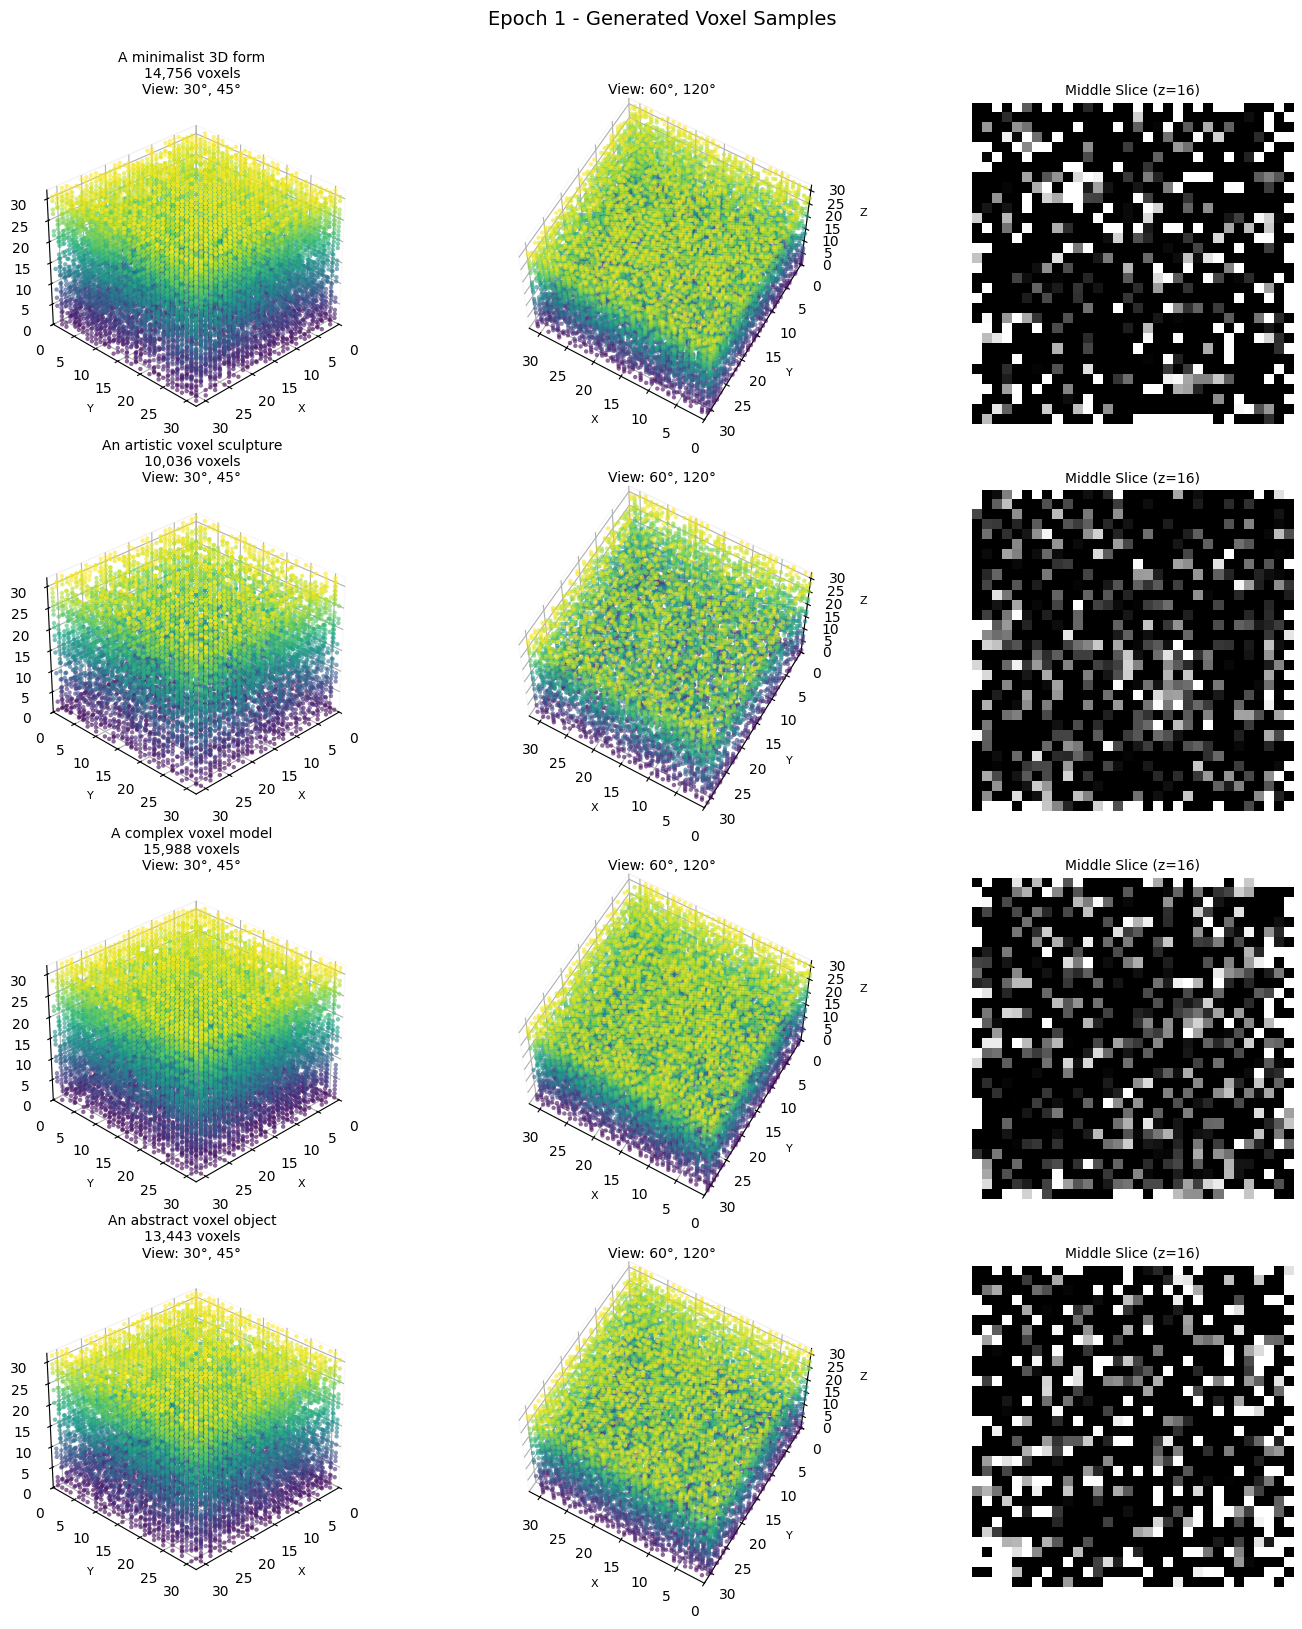

100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


Peak memory usage: 1.03 GB
3D Epoch 3/100, Average Loss: 0.0827


100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Peak memory usage: 1.03 GB
3D Epoch 4/100, Average Loss: 0.0754

Generating Epoch 3 Visualizations
Encoding text descriptions...
Generating 4 voxel samples (32³ resolution)...


Generating layers: 100%|██████████| 32/32 [11:07<00:00, 20.87s/layer, completed=100.0%]


Creating visualization plots...


Plotting samples: 100%|██████████| 4/4 [00:00<00:00, 15.75it/s]


✓ Visualization saved to: training_samples/epoch_0003_samples.png



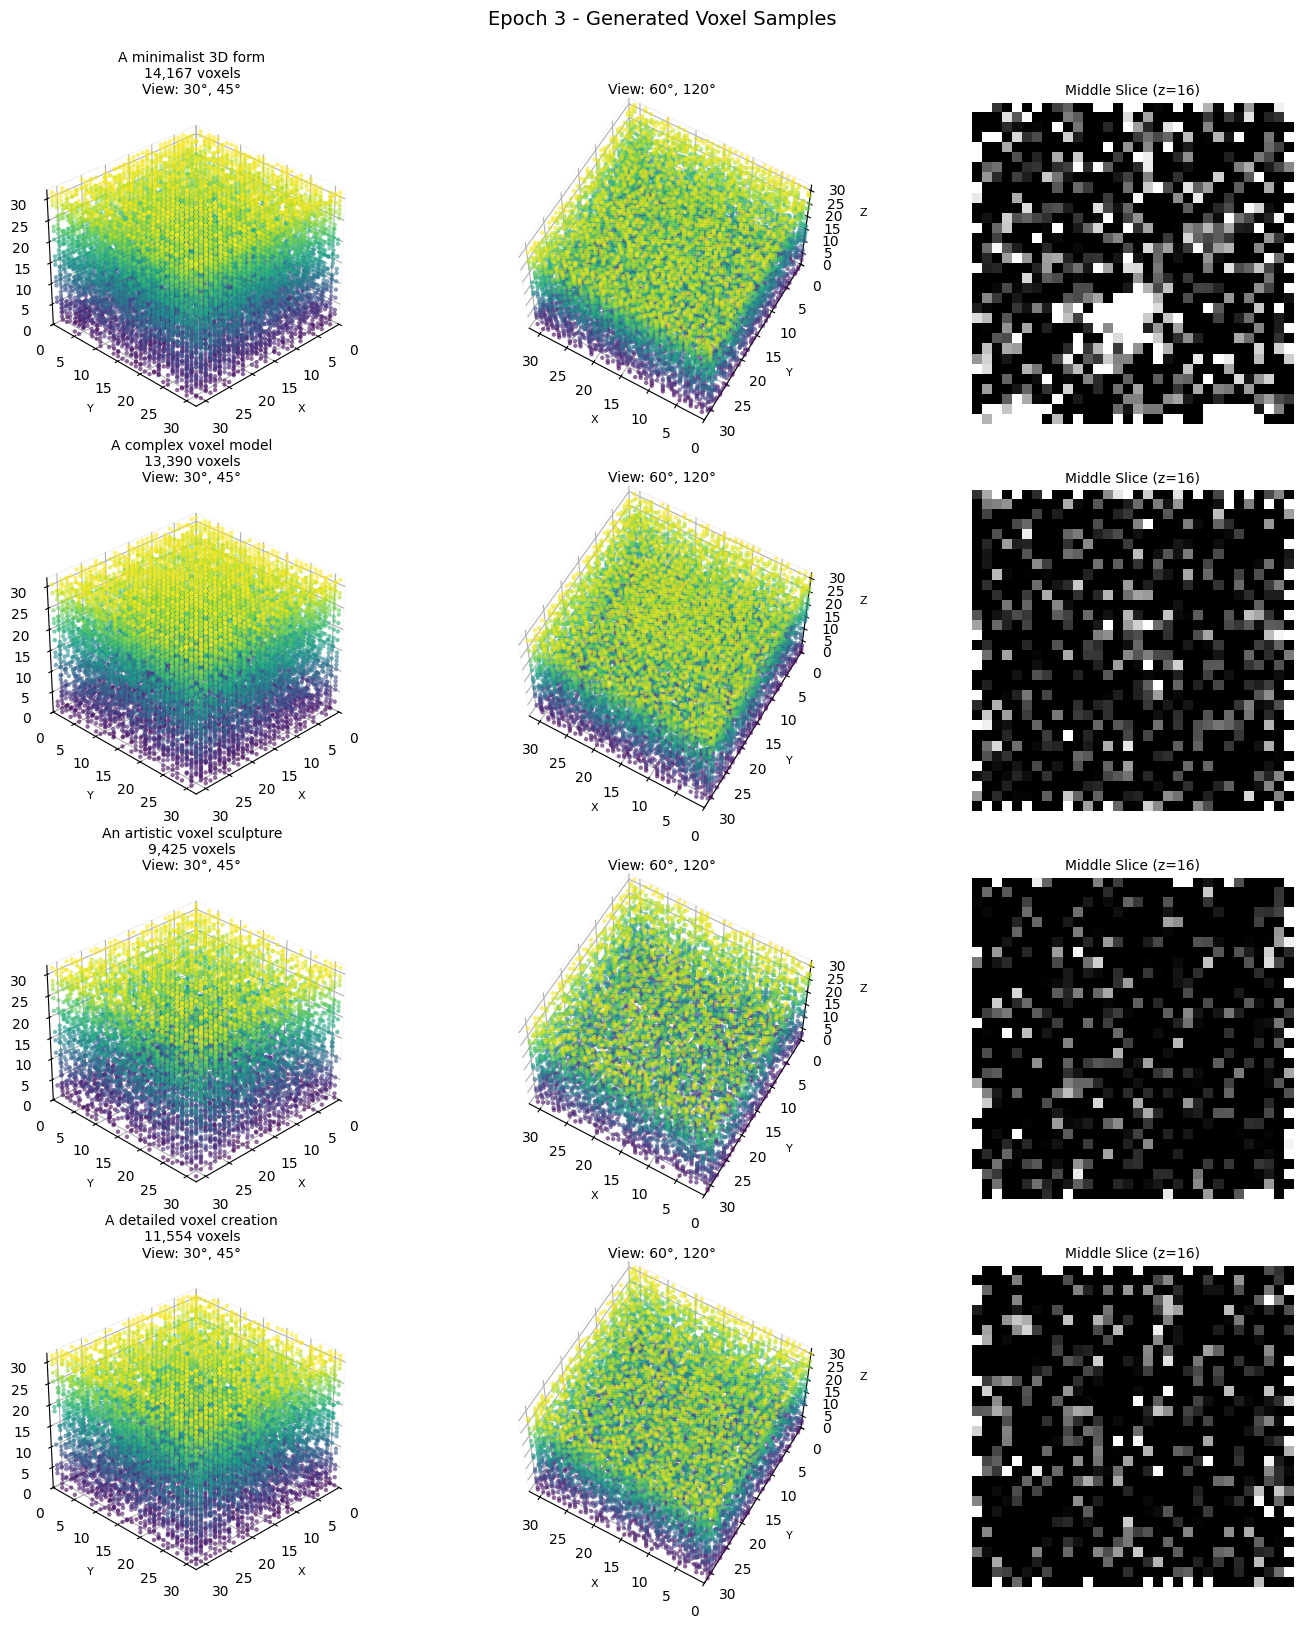

 28%|██▊       | 7/25 [00:17<00:45,  2.51s/it]


KeyboardInterrupt: 

In [ ]:
n_epochs_3d = 500
visualization_interval = 25
use_ema_3d = False

if use_ema_3d:
    ema_model_3d = ExponentialMovingAverage(layer_x_layer_model, decay=0.999)

for epoch in range(n_epochs_3d):
    epoch_loss = 0
    num_batches = 0

    # do a memory check
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 3)

    for x0, description in tqdm(dataloader_3d):
        x0 = x0.to(device)  # [B, 1, H, W, D]

        # Get context embeddings from T5
        with torch.no_grad():
            text_inputs = t5_tokenizer(
                list(description),
                padding='max_length',
                max_length=77,
                truncation=True,
                return_tensors='pt'
            ).to(device)
            
            context = t5_model(
                input_ids=text_inputs.input_ids,
                attention_mask=text_inputs.attention_mask
            ).last_hidden_state  # [B, seq_len, 768]


        
        loss = layer_x_layer_trainer.train_step(x0, context)
        epoch_loss += loss[0]
        num_batches += 1
        
        if use_ema_3d:
            ema_model_3d.update()

    print(f"Peak memory usage: {peak_memory:.2f} GB")
    
    avg_loss = epoch_loss / num_batches
    print(f"3D Epoch {epoch+1}/{n_epochs_3d}, Average Loss: {avg_loss:.4f}")

    # Sample and visualize
    if (epoch + 1) % visualization_interval == 0:  
        if use_ema_3d:
            ema_model_3d.apply_shadow()
        
        visualize_epoch_samples(
            trainer=layer_x_layer_trainer,
            epoch=epoch,
            visualizer=voxel_visualizer,
            dataset=dataloader_3d.dataset,
            context_encoder=t5_model,
            tokenizer=t5_tokenizer,
            granularity=granularity,
            device=device,
            num_samples=4  # Number of samples to generate and visualize
        )
    
    if use_ema_3d:
        ema_model_3d.restore()
            
        if use_ema_3d:
            ema_model_3d.restore

In [ ]:
visualize_epoch_samples(
    trainer=layer_x_layer_trainer,
    epoch=epoch,
    visualizer=voxel_visualizer,
    dataset=dataloader_3d.dataset,
    context_encoder=t5_model,
    tokenizer=t5_tokenizer,
    granularity=granularity,
    device=device,
    num_samples=4  # Number of samples to generate and visualize
    
)


TypeError: TrainingVoxelVisualizer.visualize_training_samples() got an unexpected keyword argument 'show_progress'

In [ ]:
# save the model
torch.save(layer_x_layer_model.state_dict(), 'layer_x_layer_diffusion_model.pth')